# Note: This notebook is in development
M. Springer 2024-06-05

In [1]:
print("Importing libraries...")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pvdeg
import xarray as xr
import os

print("Done!")

# Calculate Standoff

In [ ]:
work_dir = "/projects/pvsoiling/pvdeg/analysis/world_map/standoff_fine"
data_dir = "/projects/pvsoiling/pvdeg/analysis/world_map/data"

In [2]:
local = {
    "manager": "local",
    "n_workers": 100,
}

kestrel = {
    "manager": "slurm",
    "n_jobs": 8,  # Max number of nodes used for parallel processing
    "cores": 100,
    "processes": 50,
    "memory": "245GB",
    "account": "pvfem",
    "queue": "standard",
    "walltime": "8:00:00",
    # "scheduler_options": {"host": socket.gethostname()},
}

print("Starting Dask client...")
client = pvdeg.geospatial.start_dask(hpc=kestrel)
print("Cluster ready!")

Dashboard: http://127.0.0.1:8787/status


In [11]:
# Get weather data
weather_db = "NSRDB"

In [ ]:
weather_arg = {
    "satellite": "Himawari",
    "names": "tmy-2020",
    "NREL_HPC": True,
    "attributes": [
        "air_temperature",
        "wind_speed",
        "dhi",
        "ghi",
        "dni",
        "relative_humidity",
    ],
}

weather_ds_himawari, meta_df_himawari = pvdeg.weather.get(
    weather_db, geospatial=True, **weather_arg
)

# %%
meta_df_himawari_sub, gids_meta_df_himawari = pvdeg.utilities.gid_downsampling(
    meta_df_himawari, 3
)
weather_ds_himawari_sub = weather_ds_himawari.sel(gid=meta_df_himawari_sub.index)

# %%
geo_himawari = {
    "func": pvdeg.standards.standoff,
    "weather_ds": weather_ds_himawari_sub,
    "meta_df": meta_df_himawari_sub,
}

standoff_res_himawari = pvdeg.geospatial.analysis(**geo_himawari)
standoff_res_himawari.to_netcdf(os.path.join(work_dir, "standoff_himawari.nc"))
standoff_res_himawari.to_dataframe().to_csv(
    os.path.join(work_dir, "standoff_himawari.csv")
)

In [4]:
weather_arg = {
    "satellite": "GOES",
    "names": 2021,
    "NREL_HPC": True,
    "attributes": [
        "air_temperature",
        "wind_speed",
        "dhi",
        "ghi",
        "dni",
        "relative_humidity",
    ],
}

weather_ds_goes, meta_df_goes = pvdeg.weather.get(
    weather_db, geospatial=True, **weather_arg
)

# %%
meta_df_goes_sub, gids_meta_df_goes = pvdeg.utilities.gid_downsampling(meta_df_goes, 8)
weather_ds_goes_sub = weather_ds_goes.sel(gid=meta_df_goes_sub.index)

# %%
geo_goes = {
    "func": pvdeg.standards.standoff,
    "weather_ds": weather_ds_goes_sub,
    "meta_df": meta_df_goes_sub,
}

standoff_res_goes = pvdeg.geospatial.analysis(**geo_goes)
standoff_res_goes.to_netcdf(os.path.join(work_dir, "standoff_goes.nc"))
standoff_res_goes.to_dataframe().to_csv(os.path.join(work_dir, "standoff_goes.csv"))

In [8]:
weather_arg = {
    "satellite": "METEOSAT",
    "names": 2019,
    "NREL_HPC": True,
    "attributes": [
        "air_temperature",
        "wind_speed",
        "dhi",
        "ghi",
        "dni",
        "relative_humidity",
    ],
}

weather_ds_meteosat, meta_df_meteosat = pvdeg.weather.get(
    weather_db, geospatial=True, **weather_arg
)

# %%
meta_df_meteosat_sub, gids_meta_df_meteosat = pvdeg.utilities.gid_downsampling(
    meta_df_meteosat, 4
)
weather_ds_meteosat_sub = weather_ds_meteosat.sel(gid=meta_df_meteosat_sub.index)

# %%
geo_meteosat = {
    "func": pvdeg.standards.standoff,
    "weather_ds": weather_ds_meteosat_sub,
    "meta_df": meta_df_meteosat_sub,
}

standoff_res_meteosat = pvdeg.geospatial.analysis(**geo_meteosat)
standoff_res_meteosat.to_netcdf(os.path.join(work_dir, "standoff_meteosat.nc"))
standoff_res_meteosat.to_dataframe().to_csv(
    os.path.join(work_dir, "standoff_meteosat.csv")
)

In [30]:
# Auxillary data
import h5py

fp_weather_aux = "/projects/pvsoiling/pvdeg/data/world_map_aux.h5"
fp_meta_aux = "/projects/pvsoiling/pvdeg/data/meta_world_map_aux.csv"

# weather_aux = pvdeg.weather.read(fp_weather_aux, 'h5')
meta_aux = pd.read_csv(fp_meta_aux, index_col=0)

# xarray work around for aux data
dss = []
drop_variables = ["meta", "time_index", "tmy_year", "tmy_year_short", "coordinates"]

hf = h5py.File(fp_weather_aux, "r")
attr = list(hf)

attr_to_read = [elem for elem in attr if elem not in drop_variables]

chunks = []
shapes = []
for var in attr_to_read:
    chunks.append(hf[var].chunks if hf[var].chunks is not None else (np.nan, np.nan))
    shapes.append(hf[var].shape if hf[var].shape is not None else (np.nan, np.nan))
chunks = min(set(chunks))
shapes = min(set(shapes))


time_index = pd.to_datetime(hf["time_index"][...].astype(str)).values
meta_df = meta_aux
coords = {"gid": meta_df.index.values, "time": time_index}
coords_len = {"time": time_index.shape[0], "gid": meta_df.shape[0]}

ds = xr.open_dataset(
    fp_weather_aux,
    engine="h5netcdf",
    phony_dims="sort",
    chunks={"phony_dim_0": -1, "phony_dim_1": -1},
    drop_variables=drop_variables,
    mask_and_scale=False,
    decode_cf=True,
)

for var in ds.data_vars:
    if hasattr(getattr(ds, var), "psm_scale_factor"):
        scale_factor = 1 / ds[var].psm_scale_factor
        print(scale_factor)
        getattr(ds, var).attrs["scale_factor"] = scale_factor

rename = {}
for (
    phony,
    length,
) in ds.sizes.items():
    if length == coords_len["time"]:
        rename[phony] = "time"
    elif length == coords_len["gid"]:
        rename[phony] = "gid"
ds = ds.rename(rename)
ds = ds.assign_coords(coords)

# TODO: In case re-chunking becomes necessary
# ax0 = list(ds.sizes.keys())[list(ds.sizes.values()).index(shapes[0])]
# ax1 = list(ds.sizes.keys())[list(ds.sizes.values()).index(shapes[1])]
# ds = ds.chunk(chunks={ax0:chunks[0], ax1:chunks[1]})
dss.append(ds)

ds = xr.merge(dss)
ds = xr.decode_cf(ds)

# Rechunk time axis
ds = ds.unify_chunks()
ds = ds.chunk(chunks={"time": -1, "gid": ds.chunks["gid"]})

weather_ds = ds

DSET_MAP = {"air_temperature": "temp_air", "Relative Humidity": "relative_humidity"}
META_MAP = {"elevation": "altitude", "Local Time Zone": "tz", "timezone": "tz"}

for dset in weather_ds.data_vars:
    if dset in DSET_MAP.keys():
        weather_ds = weather_ds.rename({dset: DSET_MAP[dset]})

for mset in meta_df.columns:
    if mset in META_MAP.keys():
        meta_df.rename(columns={mset: META_MAP[mset]}, inplace=True)

weather_ds_aux = weather_ds

geo_aux = {
    "func": pvdeg.standards.standoff,
    "weather_ds": weather_ds_aux,
    "meta_df": meta_aux,
}

standoff_res_aux = pvdeg.geospatial.analysis(**geo_aux)
standoff_res_aux.to_netcdf(os.path.join(work_dir, "standoff_aux.nc"))
standoff_res_aux.to_dataframe().to_csv(os.path.join(work_dir, "standoff_aux.csv"))

/kfs2/projects/pvsoiling/pvdeg/envs/py310/lib/python3.10/site-packages/distributed/client.py:3125: UserWarning: Sending large graph of size 270.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


The array tilt angle was not provided, therefore the latitude tilt of 34.2 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 33.9 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 33.6 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 33.3 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 33.0 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 32.7 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provi

: 

: 

: 

In [ ]:
weather_db = "NSRDB"
weather_arg = {
    "satellite": "METEOSAT",
    "names": 2019,
    "NREL_HPC": True,
    "attributes": [
        "air_temperature",
        "wind_speed",
        "dhi",
        "ghi",
        "dni",
        "relative_humidity",
    ],
}
weather_ds_meteosat, meta_df_meteosat = pvdeg.weather.get(
    weather_db, geospatial=True, **weather_arg
)

time_hourly = pd.date_range("2019-01-01", freq="h", periods=365 * 24)
weather_ds_meteosat_hourly = weather_ds_meteosat.sel(time=time_hourly)

europe = [
    "Spain",
    "Portugal",  #'Ireland', 'United Kingdom',
    "France",
    "Belgium",
    "Netherlands",
    "Norway",
    "Luxembourg",
    "Germany",
    "Switzerland",
    "Italy",
    "Monaco",
    "Denmark",
    "Liechtenstein",
    "Austria",
    "Sweden",
    "Czech Republic",
    "San Marino",
    "Slovenia",
    "Croatia",
    "Poland",
    "Malta",
    "Bosnia and Herzegovina",
    "Hungary",
    "Slovakia",
    "Montenegro",
    "Serbia",
    "Albania",
    "Greece",
    "Romania",
    "Macedonia",
    "Latvia",
    "Lithuania",
    "Finland",
    "Estonia",
    "Ukraine",
    "Bulgaria",
    "Belarus",
    "Moldova",
    "Turkey",
    "Cyprus",
    "Northern Cyprus",
    "Georgia",
]

meta_df_europe = meta_df_meteosat[meta_df_meteosat["country"].isin(europe)]

meta_df_europe_sub, gids_sub = pvdeg.utilities.gid_downsampling(meta_df_europe, 4)
weather_europe_sub = weather_ds_meteosat_hourly.sel(gid=meta_df_europe_sub.index)

meta_uk = pd.read_csv("../../world_map/data/meta_pvgis_uk_4300.csv")
meta_uk_sub, gids_sub = pvdeg.utilities.gid_downsampling(meta_uk, 1)

meta_scan1 = pd.read_csv(f"{data_dir}/meta_pvgis_scan_coarse1500.csv", index_col=0)
meta_scan12 = pd.read_csv(
    f"{data_dir}/meta_pvgis_scan_coarse_1500_1599.csv", index_col=0
)
meta_scan2 = pd.read_csv(f"{data_dir}/meta_pvgis_scan_coarse2100.csv", index_col=0)
meta_scan = pd.concat([meta_scan1, meta_scan12, meta_scan2])

meta_pvgis = pd.concat([meta_scan, meta_uk_sub])

lat_NSRDB = meta_df_europe_sub["latitude"].to_numpy()
meta_pvgis["latitude_pvgis"] = meta_pvgis["latitude"]
meta_pvgis["latitude"] = meta_pvgis["latitude"].apply(
    lambda x: (
        lat_NSRDB[np.argmin(np.abs(x - lat_NSRDB))]
        if x < meta_df_europe_sub["latitude"].max()
        else x
    )
)

lon_NSRDB = meta_df_europe_sub["longitude"].to_numpy()
meta_pvgis["longitude_pvgis"] = meta_pvgis["longitude"]
meta_pvgis["longitude"] = meta_pvgis["longitude"].apply(
    lambda x: (
        lon_NSRDB[np.argmin(np.abs(x - lon_NSRDB))]
        if x > meta_df_europe_sub["longitude"].min()
        else x
    )
)
meta_pvgis["tz"] = 0
meta_pvgis = meta_pvgis.reset_index()

meta_eu_coarse = pd.concat([meta_df_europe_sub, meta_pvgis])
meta_eu_coarse["tz"] = 0
meta_eu_coarse = meta_eu_coarse.reset_index()
meta_eu_coarse.to_csv("../../world_map/data/meta_eu_coarse.csv")

weather_uk = xr.open_dataset("../../world_map/data/weather_ds_uk_4300.nc")
weather_uk = weather_uk.sel(gid=meta_uk.index)
weather_uk_sub = weather_uk.sel(gid=meta_uk_sub.index)

weather_scan1 = xr.open_dataset("../../world_map/data/weather_ds_scan_coarse1500.nc")
weather_scan12 = xr.open_dataset(
    "../../world_map/data/weather_ds_scan_coarse_1500_1599.nc"
)
weather_scan2 = xr.open_dataset("../../world_map/data/weather_ds_scan_coarse2100.nc")
weather_scan = xr.concat(
    [
        weather_scan1.sel(gid=slice(0, 1500)),
        weather_scan12.sel(gid=slice(1501, 1599)),
        weather_scan2.sel(gid=slice(1600, None)),
    ],
    dim="gid",
)
weather_scan = weather_scan.sel(gid=meta_scan.index)
# weather_scan = xr.concat([weather_scan1, weather_scan2], dim='gid')

weather_pvgis = xr.concat([weather_scan, weather_uk_sub], dim="gid")
weather_pvgis = weather_pvgis.drop_vars(["IR(h)", "wind_direction", "pressure"])

weather_pvgis = weather_pvgis.assign_coords({"gid": meta_pvgis.index})
weather_pvgis = weather_pvgis.chunk(chunks={"time": -1, "gid": 100})
weather_pvgis = weather_pvgis.unify_chunks()

meta_df_pvgis_sub, gids_meta_df_pvgis = pvdeg.utilities.gid_downsampling(meta_pvgis, 4)
weather_ds_pvgis_sub = weather_pvgis.sel(gid=meta_df_pvgis_sub.index)

# weather_europe_sub = weather_europe_sub.assign_coords({'time': pd.date_range("2022-01-01", freq="h", periods=365 * 24),})
# weather_eu_coarse = xr.concat([weather_europe_sub, weather_pvgis], dim='gid')
# weather_eu_coarse = weather_eu_coarse.assign_coords({'gid': meta_eu_coarse.index})
# weather_eu_coarse = weather_eu_coarse.chunk(chunks={"time": -1, "gid": 100})
# weather_eu_coarse = weather_eu_coarse.unify_chunks()

# with open('weather_eu_coarse.pickle', 'wb') as handle:
#     pickle.dump(weather_eu_coarse, handle, protocol=pickle.HIGHEST_PROTOCOL)


geo_pvgis = {
    "func": pvdeg.standards.standoff,
    "weather_ds": weather_pvgis,
    "meta_df": meta_pvgis,
}

standoff_res_pvgis = pvdeg.geospatial.analysis(**geo_pvgis)
standoff_res_pvgis.to_netcdf(os.path.join(work_dir, "standoff_pvgis.nc"))
standoff_res_pvgis.to_dataframe().to_csv(os.path.join(work_dir, "standoff_pvgis.csv"))

In [ ]:
meta_north = pd.read_csv(f"{data_dir}/meta_pvgis_north_3300.csv", index_col=0)
weather_north = xr.open_dataset(f"{data_dir}/weather_ds_north_3300.nc")
weather_north = weather_north.sel(gid=meta_north.index)

weather_north = weather_north.assign_coords({"gid": meta_north.index})
weather_north = weather_north.chunk(chunks={"time": -1, "gid": 100})
weather_north = weather_north.unify_chunks()


geo_pvgis = {
    "func": pvdeg.standards.standoff,
    "weather_ds": weather_north,
    "meta_df": meta_north,
}

standoff_res_pvgis = pvdeg.geospatial.analysis(**geo_pvgis)
standoff_res_pvgis.to_netcdf(os.path.join(work_dir, "standoff_pvgis_north.nc"))
standoff_res_pvgis.to_dataframe().to_csv(
    os.path.join(work_dir, "standoff_pvgis_north.csv")
)

# Post process

In [6]:
import pvdeg
import os
import pandas as pd
import numpy as np
import xarray as xr
from global_land_mask import globe
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

work_dir = "/projects/pvsoiling/pvdeg/analysis/world_map/standoff_fine"
data_dir = "/projects/pvsoiling/pvdeg/analysis/world_map/data"

In [2]:
# Create 0cm standoff locations

lon_north = np.arange(-179, 180, 0.25)
lat_north = np.arange(60, 90, 0.25)
lon_grid_north, lat_grid_north = np.meshgrid(lon_north, lat_north)
land_north = globe.is_land(lat_grid_north, lon_grid_north)
lon_land_north = lon_grid_north[land_north]
lat_land_north = lat_grid_north[land_north]

lon_south = np.arange(-179, 180, 0.25)
lat_south = np.arange(-90, -60, 0.25)
lon_grid_south, lat_grid_south = np.meshgrid(lon_south, lat_south)
land_south = globe.is_land(lat_grid_south, lon_grid_south)
lon_land_south = lon_grid_south[land_south]
lat_land_south = lat_grid_south[land_south]


lon_asia = np.arange(80, 105, 0.25)
lat_asia = np.arange(50, 61, 0.25)

lon = lon_asia
lat = np.full(lon_asia.size, 61)

for i, lat_coord in enumerate(reversed(lat_asia)):
    lon_sub = lon_asia[i:-i]
    lat_sub = np.full(lon_sub.size, lat_coord)
    lon = np.append(lon, lon_sub)
    lat = np.append(lat, lat_sub)

lon_asia = lon
lat_asia = lat

(-180.0, 180.0)

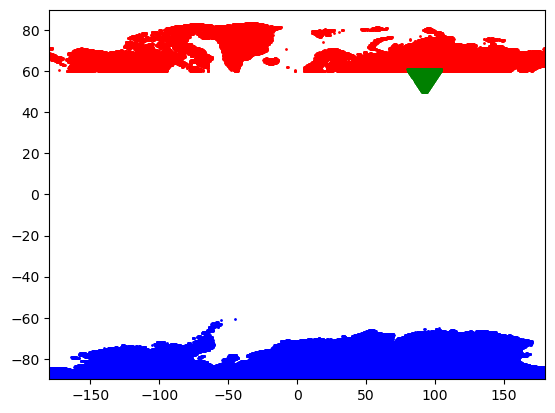

In [3]:
fig, ax = plt.subplots()

plt.scatter(lon_land_north, lat_land_north, c="r", s=1)
plt.scatter(lon_land_south, lat_land_south, c="b", s=1)
plt.scatter(lon, lat, c="g", s=1)

ax.set_ylim(-90, 90)
ax.set_xlim(-180, 180)

In [4]:
template_params = pvdeg.geospatial.template_parameters(pvdeg.standards.standoff)
standoff_zero_north = pvdeg.geospatial.zero_template(
    lat_land_north, lon_land_north, **template_params
)
standoff_zero_south = pvdeg.geospatial.zero_template(
    lat_land_south, lon_land_south, **template_params
)
standoff_zero_asia = pvdeg.geospatial.zero_template(
    lat_asia, lon_asia, **template_params
)

In [8]:
standoff_aux = xr.open_dataset(os.path.join(work_dir, "standoff_aux.nc"))
standoff_himawari = xr.open_dataset(os.path.join(work_dir, "standoff_himawari.nc"))
standoff_meteosat = xr.open_dataset(os.path.join(work_dir, "standoff_meteosat.nc"))
standoff_north = xr.open_dataset(os.path.join(work_dir, "standoff_pvgis_north.nc"))
standoff_pvgis = xr.open_dataset(os.path.join(work_dir, "standoff_pvgis.nc"))
standoff_goes = xr.open_dataset(os.path.join(work_dir, "standoff_goes.nc"))

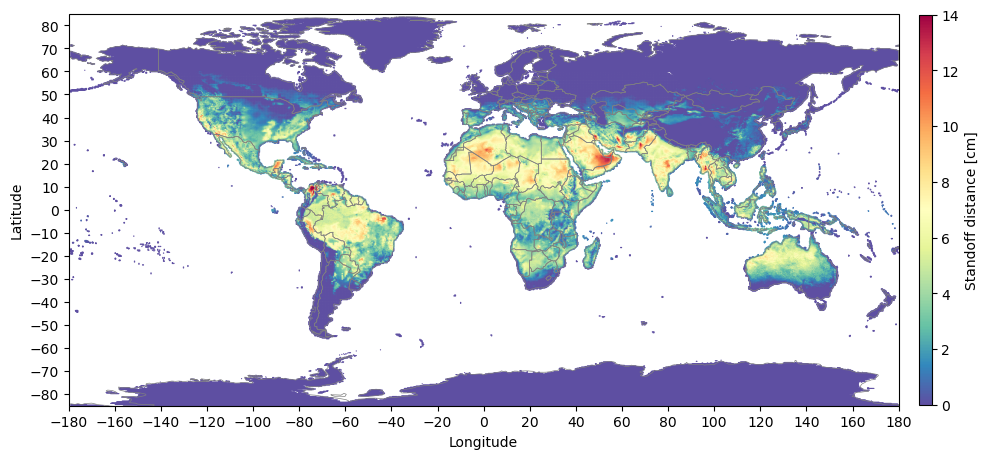

In [12]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree(), frameon=True)
ax.patch.set_visible(True)
ax.set_extent([-180, 180, -85, 85], ccrs.PlateCarree())

shapename = "admin_0_countries"
states_shp = shpreader.natural_earth(
    resolution="110m", category="cultural", name=shapename
)

cmap = "Spectral_r"
size = 0.75


standoff_zero_north.plot.scatter(
    x="longitude",
    y="latitude",
    hue="x",
    cmap=cmap,
    s=size,
    linewidths=0,
    vmin=0,
    vmax=14,
    add_colorbar=False,
    ax=ax,
)
standoff_zero_south.plot.scatter(
    x="longitude",
    y="latitude",
    hue="x",
    cmap=cmap,
    s=size,
    linewidths=0,
    vmin=0,
    vmax=14,
    add_colorbar=False,
    ax=ax,
)
standoff_zero_asia.plot.scatter(
    x="longitude",
    y="latitude",
    hue="x",
    cmap=cmap,
    s=size,
    linewidths=0,
    vmin=0,
    vmax=14,
    add_colorbar=False,
    ax=ax,
)

cm = standoff_himawari.plot.scatter(
    x="longitude",
    y="latitude",
    hue="x",
    cmap=cmap,
    s=size,
    linewidths=0,
    vmin=0,
    vmax=14,
    add_colorbar=False,
    ax=ax,
)
standoff_north.plot.scatter(
    x="longitude",
    y="latitude",
    hue="x",
    cmap=cmap,
    s=size,
    linewidths=0,
    vmin=0,
    vmax=14,
    add_colorbar=False,
    ax=ax,
)
standoff_aux.plot.scatter(
    x="longitude",
    y="latitude",
    hue="x",
    cmap=cmap,
    s=size,
    linewidths=0,
    vmin=0,
    vmax=14,
    add_colorbar=False,
    ax=ax,
)
standoff_pvgis.plot.scatter(
    x="longitude",
    y="latitude",
    hue="x",
    cmap=cmap,
    s=size,
    linewidths=0,
    vmin=0,
    vmax=14,
    add_colorbar=False,
    ax=ax,
)
standoff_meteosat.plot.scatter(
    x="longitude",
    y="latitude",
    hue="x",
    cmap=cmap,
    s=1,
    linewidths=0,
    vmin=0,
    vmax=14,
    add_colorbar=False,
    ax=ax,
)
standoff_goes.plot.scatter(
    x="longitude",
    y="latitude",
    hue="x",
    cmap=cmap,
    s=1,
    linewidths=0,
    vmin=0,
    vmax=14,
    add_colorbar=False,
    ax=ax,
)


ax.add_geometries(
    shpreader.Reader(states_shp).geometries(),
    ccrs.PlateCarree(),
    facecolor="none",
    edgecolor="gray",
    linewidth=0.5,
)

cb_title = "Standoff distance [cm]"
cb = plt.colorbar(cm, shrink=0.78, aspect=30, pad=0.02)
cb.set_label(cb_title)
# ax.set_title('title')

ax.set_xticks(np.arange(-180, 181, 20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90, 91, 10), crs=ccrs.PlateCarree())

ax.set_xlim(-180, 180)
ax.set_ylim(-85, 85)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.savefig(os.path.join(work_dir, "standoff_map.png"), dpi=1200, bbox_inches="tight")